# Temporal Convolutional Network

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My Drive/Pump Data/

/content/gdrive/My Drive/Pump Data


In [3]:
!ls

data


In [4]:
!pip install matplotlib==3.1.3
!pip install darts

     |████████████████████████████████| 13.1 MB 99 kB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 286 kB 4.3 MB/s 
     |████████████████████████████████| 1.4 MB 41.3 MB/s 
     |████████████████████████████████| 62 kB 792 kB/s 
     |████████████████████████████████| 9.8 MB 26.3 MB/s 
     |████████████████████████████████| 177 kB 51.1 MB/s 
     |████████████████████████████████| 10.3 MB 33.1 MB/s 
     |████████████████████████████████| 38.2 MB 26 kB/s 
     |████████████████████████████████| 790 kB 51.4 MB/s 
     |████████████████████████████████| 11.3 MB 31.0 MB/s 
     |████████████████████████████████| 2.0 MB 36.7 MB/s 
     |████████████████████████████████| 155 kB 47.8 MB/s 
     |████████████████████████████████| 65 kB 4.2 MB/s 
     |████████████████████████████████| 374 kB 44.9 MB/s 
     |████████████████████████████████| 49 kB 6.2 MB/s 
     |████████████████████████████████| 214 kB 51.8 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=5c1eba35d0af5de2feede2a03c8fc8530adb8f59d8c87c

In [4]:
EPOCH = 10


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta, TCNModel
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf, plot_hist
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


FC_N = 12               # forecast periods
FC_STRIDE = 10
FC_START = '2019-07-21 00:00:00'   # period at which to split training and validation dataset
DROP = 0.1
LEARN = 0.001

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset

In [7]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller, Mapper, InvertibleMapper


In [73]:
data_address = 'data'
training = pd.read_csv(data_address +'/cfp_dataset_v1.csv', index_col=False)
training.drop(['Unnamed: 0', 'MIDUPT1138P2300058', 'SHORTUPT1138P2300058', 'LONGUPT1138P2300058', 'DMIDT1138P2300058',  'DLONGT1138P2300058', 'UNIXDT', 'UUID'], axis=1, inplace=True)

In [9]:
training.columns

Index(['WELL_ID', 'DT', 'T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
       'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
       'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
       'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
       'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399',
       'DSHORTT1138P2300058'],
      dtype='object')

In [10]:
only_1_bad = training[training['WELL_ID'] == 226003316].copy()


In [11]:
only_1_bad.DT

9990     2019-07-31 23:55:00
9991     2019-07-31 23:50:00
9992     2019-07-31 23:45:00
9993     2019-07-31 23:40:00
9994     2019-07-31 23:35:00
                ...         
19972    2019-06-27 07:00:00
19973    2019-06-27 06:55:00
19974    2019-06-27 06:50:00
19975    2019-06-27 06:45:00
19976    2019-06-27 06:40:00
Name: DT, Length: 9987, dtype: object

## подготовим данные для всех насосов

In [74]:
from sklearn.preprocessing import LabelBinarizer

pump_encoder = LabelBinarizer()
transformed = pump_encoder.fit_transform(training.WELL_ID)
ohe_df = pd.DataFrame(transformed)
ohe_df.columns = pump_encoder.classes_
training_oh = pd.concat([training, ohe_df], axis=1).drop(['WELL_ID'], axis=1)
training_oh

,DT,T1138P6000096,T1138P6000315,DMIDT1138P4000064,DSHORTT1138P4000064,DLONGT1138P4000064,DMIDT1138P2600012,DSHORTT1138P2600012,DLONGT1138P2600012,DMIDT1205P2300000,DSHORTT1205P2300000,DLONGT1205P2300000,T1205P2300000,T1138P4000064,T1138P2600012,T1138P600050,T1013P500399,DSHORTT1138P2300058,226000188,226000198,226000297,226001846,226001947,226002142,226002148,226002307,226002416,226002603,226002627,226002861,226002998,226003074,226003080,226003316,226003330
0,2019-07-31 23:55:00,300,0,-2.150755,0.0,-2.290611,-0.279070,0.0,-0.313752,-0.001102,0.000587,-0.000245,1.168133,70,19.6,0.759,NaN,-0.1344,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2019-07-31 23:50:00,0,0,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.167644,70,19.6,0.761,NaN,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2019-07-31 23:45:00,0,28500,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.161290,0,0.0,0.000,NaN,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2019-07-31 23:40:00,0,28200,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.160802,0,0.0,0.000,NaN,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2019-07-31 23:35:00,0,27900,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.162268,0,0.0,0.000,NaN,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160257,2019-06-27 07:00:00,0,14400,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,0.001927,0.000000,0.000129,1.642718,0,0.0,0.000,NaN,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160258,2019-06-27 06:55:00,0,14100,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,0.001927,0.000000,0.000129,1.648583,0,0.0,0.000,NaN,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160259,2019-06-27 06:50:00,0,13800,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,0.001927,0.000000,0.000129,1.650049,0,0.0,0.000,NaN,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160260,2019-06-27 06:45:00,0,13500,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,0.001927,0.000000,0.000129,1.681818,0,0.0,0.000,NaN,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


реализовать нарезку на train-test


реализовать нарезку на файлы по названию насосов

find when to split?

In [12]:
only_1_bad['DT'] = pd.to_datetime(only_1_bad['DT'] )

print(only_1_bad.DT.min()-
      only_1_bad.DT.max())

only_1_bad.DT.min() + (only_1_bad.DT.max() - only_1_bad.DT.min()) * 0.7

-35 days +06:45:00


Timestamp('2019-07-21 13:56:29.999999999')

In [13]:
series = TimeSeries.from_dataframe(only_1_bad, 'DT', fill_missing_dates=True, freq=None)


In [14]:
scaler = Scaler()
ts = scaler.fit_transform(series)  # scale the whole time series not caring about train/val split...
filler = MissingValuesFiller()
ts = filler.transform(ts, method='quadratic')
target = ts['DSHORTT1138P2300058']
# Create training and validation sets:
train_target, val_target = target.split_after(pd.Timestamp(FC_START))

covariates = ts[['WELL_ID', 'T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
       'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
       'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
       'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
       'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399']]

train_cov, val_cov = covariates.split_after(pd.Timestamp(FC_START))
train_1cov, val_1cov = covariates['T1138P600050'].split_after(pd.Timestamp(FC_START))

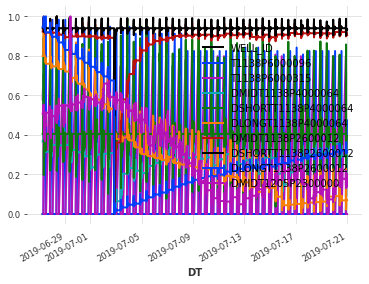

In [15]:
train_cov.plot()

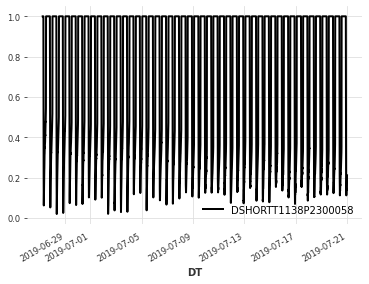

In [16]:
train_target.plot()

In [17]:
train_1cov.freq

<5 * Minutes>

In [18]:
train_1cov.pd_dataframe()

component,T1138P600050
DT,
2019-06-27 06:40:00,0.000000
2019-06-27 06:45:00,0.000000
2019-06-27 06:50:00,0.000000
2019-06-27 06:55:00,0.000000
2019-06-27 07:00:00,0.000000
...,...
2019-07-20 23:40:00,0.927178
2019-07-20 23:45:00,0.923277
2019-07-20 23:50:00,0.927178


In [19]:
train_target.describe()


component,DSHORTT1138P2300058
count,6833.000000
mean,0.747404
std,0.355612
min,0.019823
25%,0.327247
50%,1.000000
75%,1.000000
max,1.000000


In [20]:
train_target

<TimeSeries (DataArray) (DT: 6833, component: 1, sample: 1)>
array([[[1.        ]],

       [[1.        ]],

       [[1.        ]],

       ...,

       [[0.19872653]],

       [[0.20588306]],

       [[0.21142306]]])
Coordinates:
  * DT         (DT) datetime64[ns] 2019-06-27T06:40:00 ... 2019-07-21
  * component  (component) object 'DSHORTT1138P2300058'
Dimensions without coordinates: sample

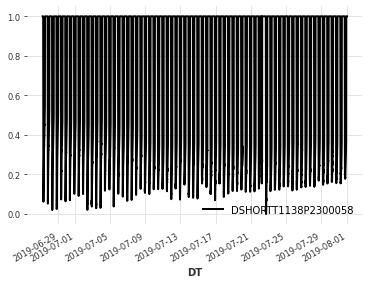

In [21]:
target.plot()

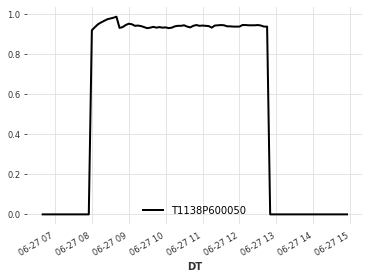

In [22]:
train_1cov[:100].plot()

In [23]:
# analyze its seasonality

is_seasonal, periodicity = check_seasonality(target, max_lag=1000)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (5*minutes)":f'{periodicity:.1f}', 
    "periodicity (hours)":f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (5*minutes) : 144.0
periodicity (hours) : 12.0


In [24]:
import statsmodels.api as sm

<AxesSubplot:xlabel='DT'>

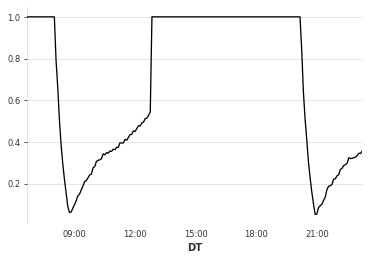

In [25]:
target.pd_dataframe().DSHORTT1138P2300058[:200].plot()

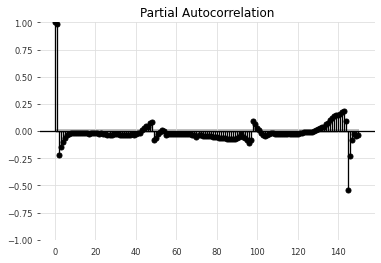

In [26]:
sm.graphics.tsa.plot_pacf(target.pd_dataframe().DSHORTT1138P2300058, lags=150)
plt.show()

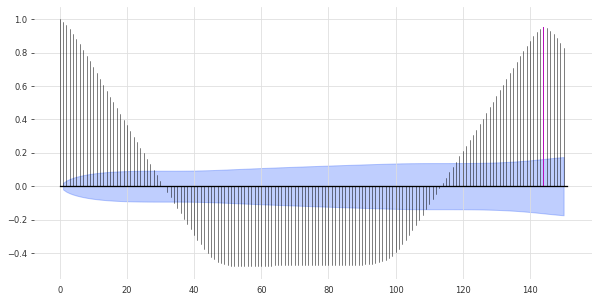

In [27]:
plot_acf(target, periodicity, max_lag=150)


In [28]:
target.describe()

component,DSHORTT1138P2300058
count,10000.000000
mean,0.750620
std,0.355972
min,0.000000
25%,0.319466
50%,1.000000
75%,1.000000
max,1.000000


In [29]:
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape, mae


# lets do a simple one

In [30]:
one_var = covariates['T1205P2300000'].copy()

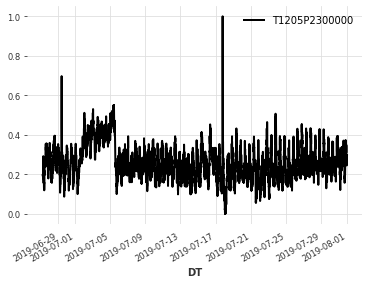

In [31]:
one_var.plot()

In [32]:
train_cov1, val_cov1 = one_var.split_after(pd.Timestamp('2019-07-21 00:00:00'))

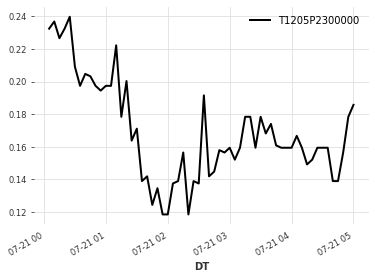

In [33]:
val_cov1[:60].plot()

In [34]:
val_cov1.time_index

DatetimeIndex(['2019-07-21 00:05:00', '2019-07-21 00:10:00',
               '2019-07-21 00:15:00', '2019-07-21 00:20:00',
               '2019-07-21 00:25:00', '2019-07-21 00:30:00',
               '2019-07-21 00:35:00', '2019-07-21 00:40:00',
               '2019-07-21 00:45:00', '2019-07-21 00:50:00',
               ...
               '2019-07-31 23:10:00', '2019-07-31 23:15:00',
               '2019-07-31 23:20:00', '2019-07-31 23:25:00',
               '2019-07-31 23:30:00', '2019-07-31 23:35:00',
               '2019-07-31 23:40:00', '2019-07-31 23:45:00',
               '2019-07-31 23:50:00', '2019-07-31 23:55:00'],
              dtype='datetime64[ns]', name='DT', length=3167, freq='5T')

In [35]:
model_1var = TCNModel(
    input_chunk_length=24,
    output_chunk_length=2,
    n_epochs=100,
    dropout=0.01,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0
)

In [36]:
model_1var.fit(series=train_target,
              past_covariates=train_cov1,
              val_series=val_target,
              val_past_covariates=val_cov1,
              verbose=True)

  1%|          | 1/100 [00:07<12:05,  7.33s/it]

 11%|█         | 11/100 [00:59<08:19,  5.61s/it]

 21%|██        | 21/100 [01:51<07:22,  5.61s/it]

 31%|███       | 31/100 [02:43<06:26,  5.59s/it]

 41%|████      | 41/100 [03:35<05:32,  5.63s/it]

 51%|█████     | 51/100 [04:27<04:35,  5.63s/it]

 61%|██████    | 61/100 [05:20<03:40,  5.66s/it]

 71%|███████   | 71/100 [06:12<02:44,  5.66s/it]

 81%|████████  | 81/100 [07:05<01:47,  5.64s/it]

 91%|█████████ | 91/100 [07:58<00:50,  5.67s/it]

100%|██████████| 100/100 [08:43<00:00,  5.23s/it]


In [37]:
backtest_1var = model_1var.historical_forecasts(series=val_target,
                                                past_covariates=val_cov1, start=0.1,
                                            retrain=False,
                                            verbose=True)


100%|██████████| 2851/2851 [00:30<00:00, 94.74it/s] 


In [39]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score


def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


In [48]:
val_target_inters = val_target.slice_intersect(backtest_1var)

MAPE = 15266777787.26%
MAE = 0.02
smape = 0.05%
smape = 0.94%


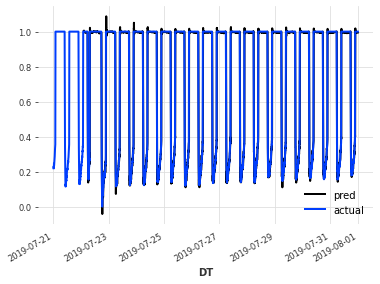

In [56]:
backtest_1var.plot(label='pred')
val_target.plot(label='actual')
plt.legend();
print('MAPE = {:.2f}%'.format(mean_absolute_percentage_error(val_target_inters.values(), backtest_1var.values())))
print('MAE = {:.2f}'.format(mae(val_target_inters, backtest_1var)))
print('smape = {:.2f}%'.format(smape(val_target_inters.values(), backtest_1var.values())))
print('R2 = {:.2f}%'.format(r2_score(val_target_inters.values(), backtest_1var.values())))


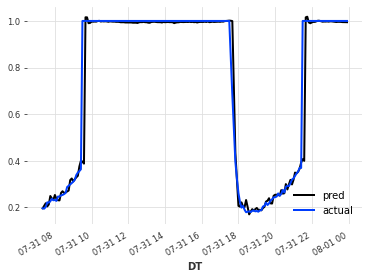

In [57]:
backtest_1var[-200:].plot(label='pred')
val_target[-200:].plot(label='actual')


## do with all covariates for 1 pump

In [ ]:
model_1pump = TCNModel(
    input_chunk_length=144,
    output_chunk_length=1,
    n_epochs=100,
    dropout=0.01,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0
)

In [ ]:
model_1pump.fit(series=train_target,
              past_covariates=train_cov,
              val_series=val_target,
              val_past_covariates=val_cov,
              verbose=True)

  1%|          | 1/100 [00:08<13:51,  8.39s/it]

 11%|█         | 11/100 [01:13<10:17,  6.94s/it]

 21%|██        | 21/100 [02:18<09:06,  6.92s/it]

 31%|███       | 31/100 [03:23<07:58,  6.93s/it]

 41%|████      | 41/100 [04:28<06:47,  6.91s/it]

 51%|█████     | 51/100 [05:33<05:40,  6.95s/it]

 61%|██████    | 61/100 [06:38<04:30,  6.93s/it]

 71%|███████   | 71/100 [07:44<03:20,  6.91s/it]

 81%|████████  | 81/100 [08:49<02:11,  6.93s/it]

 91%|█████████ | 91/100 [09:54<01:01,  6.89s/it]

100%|██████████| 100/100 [10:50<00:00,  6.51s/it]


In [ ]:
backtest_1pump = model_1pump.historical_forecasts(series=val_target,
                                                past_covariates=val_cov, start=0.1,
                                            retrain=False,
                                            verbose=True)


100%|██████████| 2851/2851 [00:35<00:00, 81.06it/s]


In [ ]:
val_1pumptarget_inters = val_target.slice_intersect(backtest_1pump)

MAPE = 5.10%
MAE = 0.02


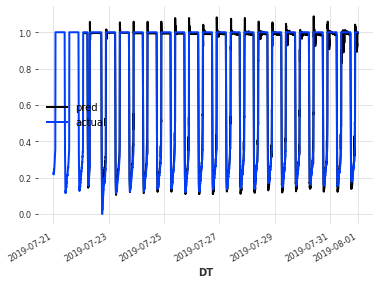

In [ ]:
backtest_1pump.plot(label='pred')
val_target.plot(label='actual')
plt.legend();
print('MAPE = {:.2f}%'.format(mean_absolute_percentage_error(val_1pumptarget_inters.values(), backtest_1pump.values())))
print('MAE = {:.2f}'.format(mae(val_1pumptarget_inters, backtest_1pump)))
print('smape = {:.2f}%'.format(smape(val_1pumptarget_inters.values(), backtest_1pump.values())))
print('R2 = {:.2f}%'.format(r2_score(val_1pumptarget_inters.values(), backtest_1pump.values())))


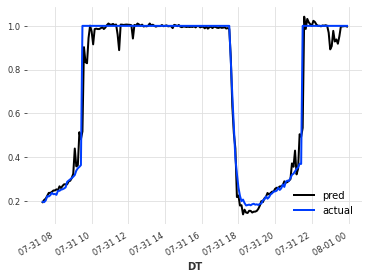

In [ ]:
backtest_1pump[-200:].plot(label='pred')
val_target[-200:].plot(label='actual')

## сделаем теперь обучение на множестве временных рядов

## запустим более подробно с графиками

на основе https://github.com/h3ik0th/Darts_TCN_RNN/blob/main/darts07%20TCN%20RNN.ipynb 

In [ ]:
# helper function: plot the predictions

def plot_fitted(pred, act, flavor):
    act2 = act.slice(act.start_time(), pred.end_time())
    plt.figure(figsize=(12,5))
    act2.plot(label='actual')
    pred.plot(label='prediction')
    if flavor == "TCN":
        plt_title = "TCN"
    else:
        plt_title = "RNN: {0} flavor"
    plt.title(plt_title.format(flavor) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.legend();

In [ ]:
# set up, fit, run, plot, and evaluate the TCN model

def run_TCN():

    model_TCN = TCNModel(
        input_chunk_length=13, #FC_N+1,
        output_chunk_length=12, #FC_N, 
        n_epochs=EPOCH,
        dropout=DROP,
        dilation_base=2,
        weight_norm=True,
        batch_size=16,
        kernel_size=5,
        num_filters=3,
        optimizer_kwargs={'lr': LEARN},
        log_tensorboard=True,
        force_reset=True,
        random_state=42)


    t_start =  time.perf_counter()
    print("\nbeginning the training of the TCN model")
    model_TCN.fit(
                series=train_trf,
                past_covariates=cov_train,
                val_series=val_trf,
                val_past_covariates=cov_val,
                verbose=True)
    res_time = time.perf_counter() - t_start
    print("training of the TCN has completed: ", f'{res_time:.2f} sec')


    # compute N predictions
    #pred = model_TCN.predict(FC_N, past)
    pred = model_TCN.predict(12,
                series=train_trf,
                past_covariates=cov_train)

    # plot predictions vs actual
    plot_fitted(pred, ts_trf, "TCN")

    # print accuracy metrics
    res_acc = accuracy_metrics(pred, ts_trf)    
    print("TCN:")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return [pred, res_acc]

In [ ]:
# run TCN on the time series:
models = ["TCN"]

# call the model setup for each of the models
res_models = [run_TCN() if m == "TCN" else run_RNN(m) for m in models]

# sunspots example

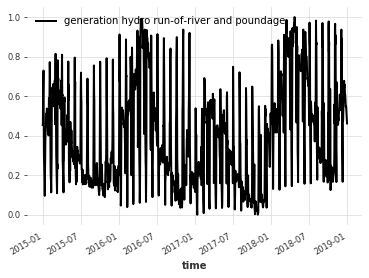

In [ ]:
df3 = EnergyDataset().load().pd_dataframe()
df3_day_avg = df3.groupby(df3.index.astype(str).str.split(" ").str[0]).mean().reset_index()
series_en = fill_missing_values(TimeSeries.from_dataframe(df3_day_avg, 'time', ['generation hydro run-of-river and poundage']), 'auto')

# scale
scaler_en = Scaler()
series_en_transformed = scaler_en.fit_transform(series_en)
train_en_transformed, val_en_transformed = series_en_transformed.split_after(pd.Timestamp('20170901'))

# add the day as a covariate
day_series = datetime_attribute_timeseries(series_en_transformed, attribute='day', one_hot=True)
scaler_day = Scaler()
day_series = scaler_day.fit_transform(day_series)
train_day, val_day = day_series.split_after(pd.Timestamp('20170901'))

series_en_transformed.plot()

In [ ]:
model_en = TCNModel(
    input_chunk_length=365,
    output_chunk_length=7,
    n_epochs=50,
    dropout=0.2,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=8,
    nr_epochs_val_period=1,
    random_state=0
)

In [ ]:
model_en.fit(series=train_en_transformed,
             past_covariates=train_day,
             verbose=True)

[2021-11-07 11:08:36,671] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 605 samples.
[2021-11-07 11:08:36,671] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 605 samples.
[2021-11-07 11:08:36,683] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 6
[2021-11-07 11:08:36,683] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 6
[2021-11-07 11:08:36,701] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-11-07 11:08:36,701] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
  2%|▏         | 1/50 [00:02<01:46,  2.17s/it]

  4%|▍         | 2/50 [00:04<01:44,  2.17s/it]

  6%|▌         | 3/50 [00:06<01:40,  2.14s/it]

  8%|▊         | 4/50 [00:08<01:38,  2.15s/it]

 10%|█         | 5/50 [00:10<01:35,  2.12s/it]

 12%|█▏        | 6/50 [00:13<01:38,  2.23s/it]

 14%|█▍        | 7/50 [00:15<01:33,  2.18s/it]

 16%|█▌        | 8/50 [00:17<01:30,  2.16s/it]

 18%|█▊        | 9/50 [00:19<01:27,  2.14s/it]

 20%|██        | 10/50 [00:21<01:24,  2.12s/it]

 22%|██▏       | 11/50 [00:23<01:22,  2.12s/it]

 24%|██▍       | 12/50 [00:25<01:20,  2.11s/it]

 26%|██▌       | 13/50 [00:27<01:17,  2.10s/it]

 28%|██▊       | 14/50 [00:29<01:15,  2.10s/it]

 30%|███       | 15/50 [00:31<01:13,  2.09s/it]

 32%|███▏      | 16/50 [00:34<01:11,  2.10s/it]

 34%|███▍      | 17/50 [00:36<01:08,  2.09s/it]

 36%|███▌      | 18/50 [00:38<01:06,  2.09s/it]

 38%|███▊      | 19/50 [00:40<01:04,  2.09s/it]

 40%|████      | 20/50 [00:42<01:02,  2.09s/it]

 42%|████▏     | 21/50 [00:44<01:00,  2.08s/it]

 44%|████▍     | 22/50 [00:46<00:57,  2.06s/it]

 46%|████▌     | 23/50 [00:48<00:55,  2.06s/it]

 48%|████▊     | 24/50 [00:50<00:53,  2.06s/it]

 50%|█████     | 25/50 [00:52<00:51,  2.07s/it]

 52%|█████▏    | 26/50 [00:54<00:49,  2.07s/it]

 54%|█████▍    | 27/50 [00:56<00:47,  2.07s/it]

 56%|█████▌    | 28/50 [00:58<00:45,  2.07s/it]

 58%|█████▊    | 29/50 [01:01<00:43,  2.09s/it]

 60%|██████    | 30/50 [01:03<00:41,  2.09s/it]

 62%|██████▏   | 31/50 [01:05<00:39,  2.08s/it]

 64%|██████▍   | 32/50 [01:07<00:37,  2.09s/it]

 66%|██████▌   | 33/50 [01:09<00:35,  2.08s/it]

 68%|██████▊   | 34/50 [01:11<00:33,  2.09s/it]

 70%|███████   | 35/50 [01:13<00:31,  2.08s/it]

 72%|███████▏  | 36/50 [01:15<00:28,  2.07s/it]

 74%|███████▍  | 37/50 [01:17<00:26,  2.07s/it]

 76%|███████▌  | 38/50 [01:19<00:24,  2.07s/it]

 78%|███████▊  | 39/50 [01:21<00:22,  2.07s/it]

 80%|████████  | 40/50 [01:23<00:20,  2.06s/it]

 82%|████████▏ | 41/50 [01:25<00:18,  2.06s/it]

 84%|████████▍ | 42/50 [01:27<00:16,  2.06s/it]

 86%|████████▌ | 43/50 [01:29<00:14,  2.07s/it]

 88%|████████▊ | 44/50 [01:32<00:12,  2.08s/it]

 90%|█████████ | 45/50 [01:34<00:10,  2.07s/it]

 92%|█████████▏| 46/50 [01:36<00:08,  2.07s/it]

 94%|█████████▍| 47/50 [01:38<00:06,  2.06s/it]

 96%|█████████▌| 48/50 [01:40<00:04,  2.07s/it]

 98%|█████████▊| 49/50 [01:42<00:02,  2.10s/it]

100%|██████████| 50/50 [01:44<00:00,  2.09s/it]

100%|██████████| 434/434 [00:06<00:00, 64.64it/s]


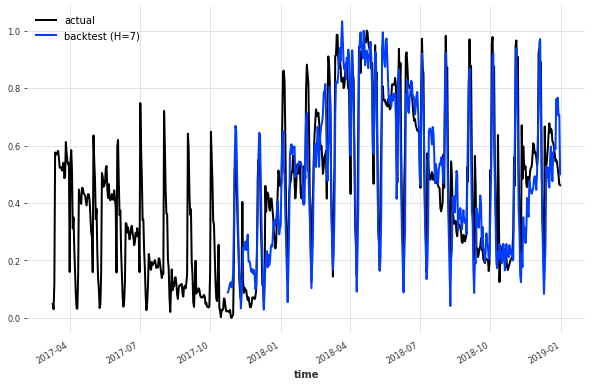

In [ ]:
backtest_en = model_en.historical_forecasts(series=series_en_transformed,
                                            past_covariates=day_series,
                                            start=0.7,
                                            forecast_horizon=7,
                                            stride=1,
                                            retrain=False,
                                            verbose=True)

plt.figure(figsize=(10,6))
series_en_transformed[800:].plot(label='actual')
backtest_en.plot(label='backtest (H=7)')
plt.legend();

### иллюстрация проблем с mape


In [ ]:
trues = pd.DataFrame({'DT':['15:10:00', '15:11:00', '15:12:00'], 'value':[0,0,0]})
pred_mock = pd.DataFrame({'DT':['15:10:00', '15:11:00', '15:12:00'], 'value':[0.1,0.1,0.1]})

In [ ]:
seriestrue = TimeSeries.from_dataframe(trues, 'DT', fill_missing_dates=True, freq=None)
seriesmock = TimeSeries.from_dataframe(pred_mock, 'DT', fill_missing_dates=True, freq=None)

seriesmock

<TimeSeries (DataArray) (DT: 3, component: 1, sample: 1)>
array([[[0.1]],

       [[0.1]],

       [[0.1]]])
Coordinates:
  * DT         (DT) datetime64[ns] 2021-11-07T15:10:00 ... 2021-11-07T15:12:00
  * component  (component) object 'value'
Dimensions without coordinates: sample

In [ ]:
mape(seriestrue, seriesmock)

ValueError: ignored